# **AutoML**



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

### Установка LightAutoML

In [ ]:
%pip install lightautoml

  Using cached lightautoml-0.4.2-py3-none-any.whl.metadata (13 kB)
  Using cached sqlalchemy-2.0.45-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached autowoe-1.3.4-py3-none-any.whl.metadata (3.5 kB)
  Using cached catboost-1.2.8-cp313-cp313-win_amd64.whl.metadata (1.5 kB)
  Using cached cmaes-0.12.0-py3-none-any.whl.metadata (29 kB)
  Using cached holidays-0.86-py3-none-any.whl.metadata (50 kB)
  Using cached json2html-1.3.0.tar.gz (7.0 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached optuna-4.6.0-py3-none-any.whl.metadata (17 kB)
  Using cached poetry_core-1.9.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached s

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [87 lines of output]
      <string>:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
      Compiling statsmodels/tsa/stl/_stl.pyx because it depends on C:\Users\luita\AppData\Local\Temp\pip-build-env-1e0kvnb3\overlay\Lib\site-packages\Cython\Includes\libc\math.pxd.
      Compiling statsmodels/tsa/holtwinters/_exponential_smoothers.pyx because it depends on C:\Users\luita\AppData\Local\Temp\pip-build-env-1e0kvnb3\overlay\Lib\site-packages\Cython\Includes\libc\string.pxd.
      Compiling statsmodels/tsa/exponential_smoothing/_ets_smooth.pyx because it depends on C:\Users\luita\AppData\Local\Temp\pip-build-env-1e0kvnb3\overlay\Lib\site-packages\Cython\Includes\libc\st

### Импорт необходимых зависимостей

In [3]:
import os
import time
import re
import requests

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

ModuleNotFoundError: No module named 'lightautoml'

: 

In [ ]:
%%time
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.4 µs


### Определение констант

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TRAIN_SIZE = 600000
TIMEOUT = 7200
TARGET_NAME = 'Response'
DATASET_URL = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

In [ ]:
DATASET_URL = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

Настройка количества потоков Torch и seed NumPy

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### Загрузка датасета

In [ ]:
data = pd.read_csv(DATASET_URL)
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.00,0,1-2 Year,Yes,"65,101.00",124.00,187,0
1,1,Male,43,1,28.00,0,> 2 Years,Yes,"58,911.00",26.00,288,1
2,2,Female,25,1,14.00,1,< 1 Year,No,"38,043.00",152.00,254,0
3,3,Female,35,1,1.00,0,1-2 Year,Yes,"2,630.00",156.00,76,0
4,4,Female,36,1,15.00,1,1-2 Year,No,"31,951.00",152.00,294,0


In [ ]:
data.shape

(11504798, 12)

### Разделение выборок

Используем параметр train_size=500000, чтобы выборка для обучения не занимала слишком много времени и stratify, чтобы сбалансировать выборки по таргету.
Для AutoML не проводим никакую предобработку данных

In [ ]:
train_data, test_data = train_test_split(
    data,
    test_size=TEST_SIZE,
    train_size=TRAIN_SIZE,
    stratify=data[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Тренировочная выборка: = {train_data.shape}, тестовая выборка = {test_data.shape}')

train_data.head()

Тренировочная выборка: = (600000, 12), тестовая выборка = (2300960, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
8647512,8647512,Male,44,1,26.00,0,1-2 Year,Yes,"31,881.00",156.00,80,0
11258282,11258282,Female,54,1,29.00,1,1-2 Year,No,"32,729.00",152.00,119,0
4685220,4685220,Female,25,1,28.00,1,< 1 Year,No,"50,818.00",152.00,119,0
11474490,11474490,Male,43,1,28.00,1,1-2 Year,No,"33,410.00",26.00,209,0
9877022,9877022,Male,27,1,6.00,1,< 1 Year,No,"33,109.00",152.00,166,0


Создаем задачу по бинарной классификации. Оставим пока дефолтную метрику библиотеку для бинарной классификации - ROC-AUC

In [ ]:
task = Task('binary')

Устанавиваем значения признаков

In [ ]:
roles = {
    'target': TARGET_NAME,
    'numeric': ['Age', 'Annual_Premium', 'Vintage'],
    'category': ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel'],
    'drop': ['id'] # удаляем id, так как этот параметр неинформативный и не влияет на прогноз
}

### Создание AutoML модели

In [ ]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

### Запуск AutoML модели

In [ ]:
%%time
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[22:03:16] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[22:03:16] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[22:03:16] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[22:03:16] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[22:03:16] - time: 7200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 7200.00 seconds


[22:03:16] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[22:03:16] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[22:03:16] Train data shape: (600000, 12)



INFO:lightautoml.reader.base:Train data shape: (600000, 12)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[22:03:34] Layer 1 train process start. Time left 7181.66 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 7181.66 secs


[22:03:58] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2, 3], 'embed_sizes': array([ 3,  3,  4, 11], dtype=int32), 'data_size': 22}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8397969035440155
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.8509686553942704
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8525211871957779
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8534900676984132
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 sc

[22:04:52] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.85255657434185


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.85255657434185


[22:04:52] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[22:04:52] Time left 7103.95 secs



INFO:lightautoml.automl.base:Time left 7103.95 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.863955
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.864171
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[152]	valid's auc: 0.864374


[22:05:15] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[22:05:40] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 2000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.864662
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.864454
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[122]	valid's auc: 0.864793
INFO2:lightautoml.ml_algo.base:===== Start working wi

[22:08:05] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8641014629475144


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8641014629475144


[22:08:05] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[22:08:05] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-9c273625-f0cf-47f8-967a-ff41ee27e10a
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.864816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.864749
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[144]	valid's auc: 0.864976
INFO:optuna.study.study:Trial 0 finished with value: 0.8649762894643493 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.864976

[22:13:23] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}
 achieve 0.8659 auc


[22:13:23] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 223, 'feature_fraction': 0.5290418060840998, 'bagging_fraction': 0.8005575058716043, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.679657809075816}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.865563
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.865859
INFO3:lightautoml.ml_algo.boos

[22:16:01] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8651128764164561


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8651128764164561


[22:16:01] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[22:16:01] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8184595	best: 0.8184595 (0)	total: 322ms	remaining: 16m 6s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8528407	best: 0.8528407 (100)	total: 10.7s	remaining: 5m 7s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.8543334	

[22:22:00] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8539919626051213


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8539919626051213


[22:22:00] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[22:22:00] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c0a028af-feb8-41bb-8998-949ed932d131
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8174749	best: 0.8174749 (0)	total: 235ms	remaining: 11m 44s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8520242	best: 0.8520242 (100)	total: 8.94s	remaining: 4m 16s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.8540227	best: 0.8540227 (200)	total: 18.7s	remaining: 4m 20s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.8547871	best: 0.8547871 (300)	total: 28.2s	remaining: 4m 13s
INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.8552482	best: 0.8552482 (400)	total: 37s	remaining: 3m 59s
INFO3:lightautoml.ml_algo.boost_cb:500:	test: 0.8555959	best: 0.8555959 (500)	total: 45.9s	remaining: 3m 49s
INFO3:lightautoml.ml_algo.bo

[22:27:47] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}
 achieve 0.8561 auc


[22:27:47] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 3.6010467344475403, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 15, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8174749	best: 0.8174749 (0)	total: 90.1ms	remaining: 4m 30s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8501115	best: 0.8501115 (100)	total: 10.4s	remaining: 4m 57s
INFO3:lightautoml.ml_algo.b

[22:43:48] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.8543525528076021


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.8543525528076021


[22:43:48] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[22:43:48] Time left 4768.15 secs



INFO:lightautoml.automl.base:Time left 4768.15 secs



[22:43:48] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[22:43:48] Blending: optimization starts with equal weights. Score = 0.8653928


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.8653928


[22:43:55] Blending: iteration 0: score = 0.8685961, weights = [0.25390294 0.389064   0.35703307 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.8685961, weights = [0.25390294 0.389064   0.35703307 0.         0.        ]


[22:44:02] Blending: iteration 1: score = 0.8692845, weights = [0.37268072 0.26167023 0.365649   0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.8692845, weights = [0.37268072 0.26167023 0.365649   0.         0.        ]


[22:44:08] Blending: iteration 2: score = 0.8693301, weights = [0.37997267 0.20995188 0.41007546 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.8693301, weights = [0.37997267 0.20995188 0.41007546 0.         0.        ]


[22:44:16] Blending: iteration 3: score = 0.8693516, weights = [0.38335618 0.17378066 0.44286317 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = 0.8693516, weights = [0.38335618 0.17378066 0.44286317 0.         0.        ]


[22:44:22] Blending: iteration 4: score = 0.8693624, weights = [0.38569984 0.14705817 0.46724197 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 4: score = 0.8693624, weights = [0.38569984 0.14705817 0.46724197 0.         0.        ]


[22:44:22] Blending: best score = 0.8693624, best weights = [0.38569984 0.14705817 0.46724197 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: best score = 0.8693624, best weights = [0.38569984 0.14705817 0.46724197 0.         0.        ]


[22:44:22] Automl preset training completed in 2466.33 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 2466.33 seconds



[22:44:22] Model description:
Final prediction for new objects (level 0) = 
	 0.38570 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.14706 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.46724 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.38570 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.14706 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.46724 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



CPU times: user 1h 7min 49s, sys: 1min 48s, total: 1h 9min 38s
Wall time: 41min 6s


### Предсказания AutoML модели

In [ ]:
%%time

test_predictions = automl.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[0.00090136],
       [0.00038278],
       [0.3552642 ],
       ...,
       [0.05867296],
       [0.33095247],
       [0.0518036 ]], dtype=float32)
Shape = (2300960, 1)
CPU times: user 10min 33s, sys: 6.62 s, total: 10min 40s
Wall time: 6min 50s


In [ ]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.8693623522678265
HOLDOUT score: 0.8688241104347044


In [ ]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [ ]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

In [ ]:
%%time
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[00:42:33] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[00:42:33] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[00:42:33] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[00:42:33] - time: 7200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 7200.00 seconds


[00:42:33] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[00:42:33] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[00:42:33] Train data shape: (600000, 12)



INFO:lightautoml.reader.base:Train data shape: (600000, 12)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[00:43:02] Layer 1 train process start. Time left 7170.80 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 7170.80 secs


[00:43:29] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2, 3], 'embed_sizes': array([ 3,  3,  4, 11], dtype=int32), 'data_size': 22}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8397969035440155
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.8509686553942704
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8525211871957779
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8534900676984132
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 sc

[00:44:23] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.85255657434185


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.85255657434185


[00:44:23] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[00:44:23] Time left 7090.11 secs



INFO:lightautoml.automl.base:Time left 7090.11 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.863955
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.864171
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[152]	valid's auc: 0.864374


[00:44:44] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[00:45:09] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 2000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.864662
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.864454
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[122]	valid's auc: 0.864793
INFO2:lightautoml.ml_algo.base:===== Start working wi

[00:47:27] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8641014629475144


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8641014629475144


[00:47:27] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[00:47:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-e6763cb6-9a04-41c1-ae57-8ad2c94d3a4a
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.864816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.864749
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[144]	valid's auc: 0.864976
INFO:optuna.study.study:Trial 0 finished with value: 0.8649762894643493 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.864976

[00:53:15] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}
 achieve 0.8663 auc


[00:53:15] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 60, 'feature_fraction': 0.7733551396716398, 'bagging_fraction': 0.9847923138822793, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 1.2604664585649468}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.864361
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.865683
INFO3:lightautoml.ml_algo.boost_lg

[00:57:18] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8656201176390966


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8656201176390966


[00:57:18] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[00:57:18] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8184595	best: 0.8184595 (0)	total: 105ms	remaining: 5m 14s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8528407	best: 0.8528407 (100)	total: 10.2s	remaining: 4m 53s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.8543334

[01:03:11] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8539919626051213


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8539919626051213


[01:03:11] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[01:03:11] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-782989f2-73be-4d28-bd1e-9a0bc40d94c8
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8174749	best: 0.8174749 (0)	total: 251ms	remaining: 12m 32s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8520242	best: 0.8520242 (100)	total: 9.45s	remaining: 4m 31s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.8540227	best: 0.8540227 (200)	total: 19s	remaining: 4m 25s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.8547871	best: 0.8547871 (300)	total: 28.3s	remaining: 4m 14s
INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.8552482	best: 0.8552482 (400)	total: 36.4s	remaining: 3m 55s
INFO3:lightautoml.ml_algo.boost_cb:500:	test: 0.8555959	best: 0.8555959 (500)	total: 45.8s	remaining: 3m 48s
INFO3:lightautoml.ml_algo.bo

[01:08:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}
 achieve 0.8561 auc


[01:08:54] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 3.6010467344475403, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 15, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8174749	best: 0.8174749 (0)	total: 196ms	remaining: 9m 47s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8501115	best: 0.8501115 (100)	total: 9.35s	remaining: 4m 28s
INFO3:lightautoml.ml_algo.bo

[01:24:50] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.8543525528076021


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.8543525528076021


[01:24:50] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[01:24:50] Time left 4663.04 secs



INFO:lightautoml.automl.base:Time left 4663.04 secs



[01:24:50] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[01:24:50] Blending: optimization starts with equal weights. Score = 0.8655034


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.8655034


[01:24:57] Blending: iteration 0: score = 0.8687294, weights = [0.23244873 0.3525726  0.41497868 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.8687294, weights = [0.23244873 0.3525726  0.41497868 0.         0.        ]


[01:25:04] Blending: iteration 1: score = 0.8695745, weights = [0.36742795 0.21394189 0.4186302  0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.8695745, weights = [0.36742795 0.21394189 0.4186302  0.         0.        ]


[01:25:11] Blending: iteration 2: score = 0.8696290, weights = [0.3742953  0.15677314 0.4689316  0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.8696290, weights = [0.3742953  0.15677314 0.4689316  0.         0.        ]


[01:25:18] Blending: iteration 3: score = 0.8696545, weights = [0.37834394 0.11565541 0.50600064 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = 0.8696545, weights = [0.37834394 0.11565541 0.50600064 0.         0.        ]


[01:25:26] Blending: iteration 4: score = 0.8696645, weights = [0.38042203 0.08960711 0.5299709  0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 4: score = 0.8696645, weights = [0.38042203 0.08960711 0.5299709  0.         0.        ]


[01:25:26] Blending: best score = 0.8696645, best weights = [0.38042203 0.08960711 0.5299709  0.         0.        ]


INFO:lightautoml.automl.blend:Blending: best score = 0.8696645, best weights = [0.38042203 0.08960711 0.5299709  0.         0.        ]


[01:25:26] Automl preset training completed in 2572.84 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 2572.84 seconds



[01:25:26] Model description:
Final prediction for new objects (level 0) = 
	 0.38042 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.08961 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.52997 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.38042 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.08961 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.52997 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



CPU times: user 1h 10min 39s, sys: 1min 46s, total: 1h 12min 26s
Wall time: 42min 58s


CPU times: user 166 ms, sys: 3.05 ms, total: 169 ms
Wall time: 329 ms


<Axes: xlabel='Feature'>

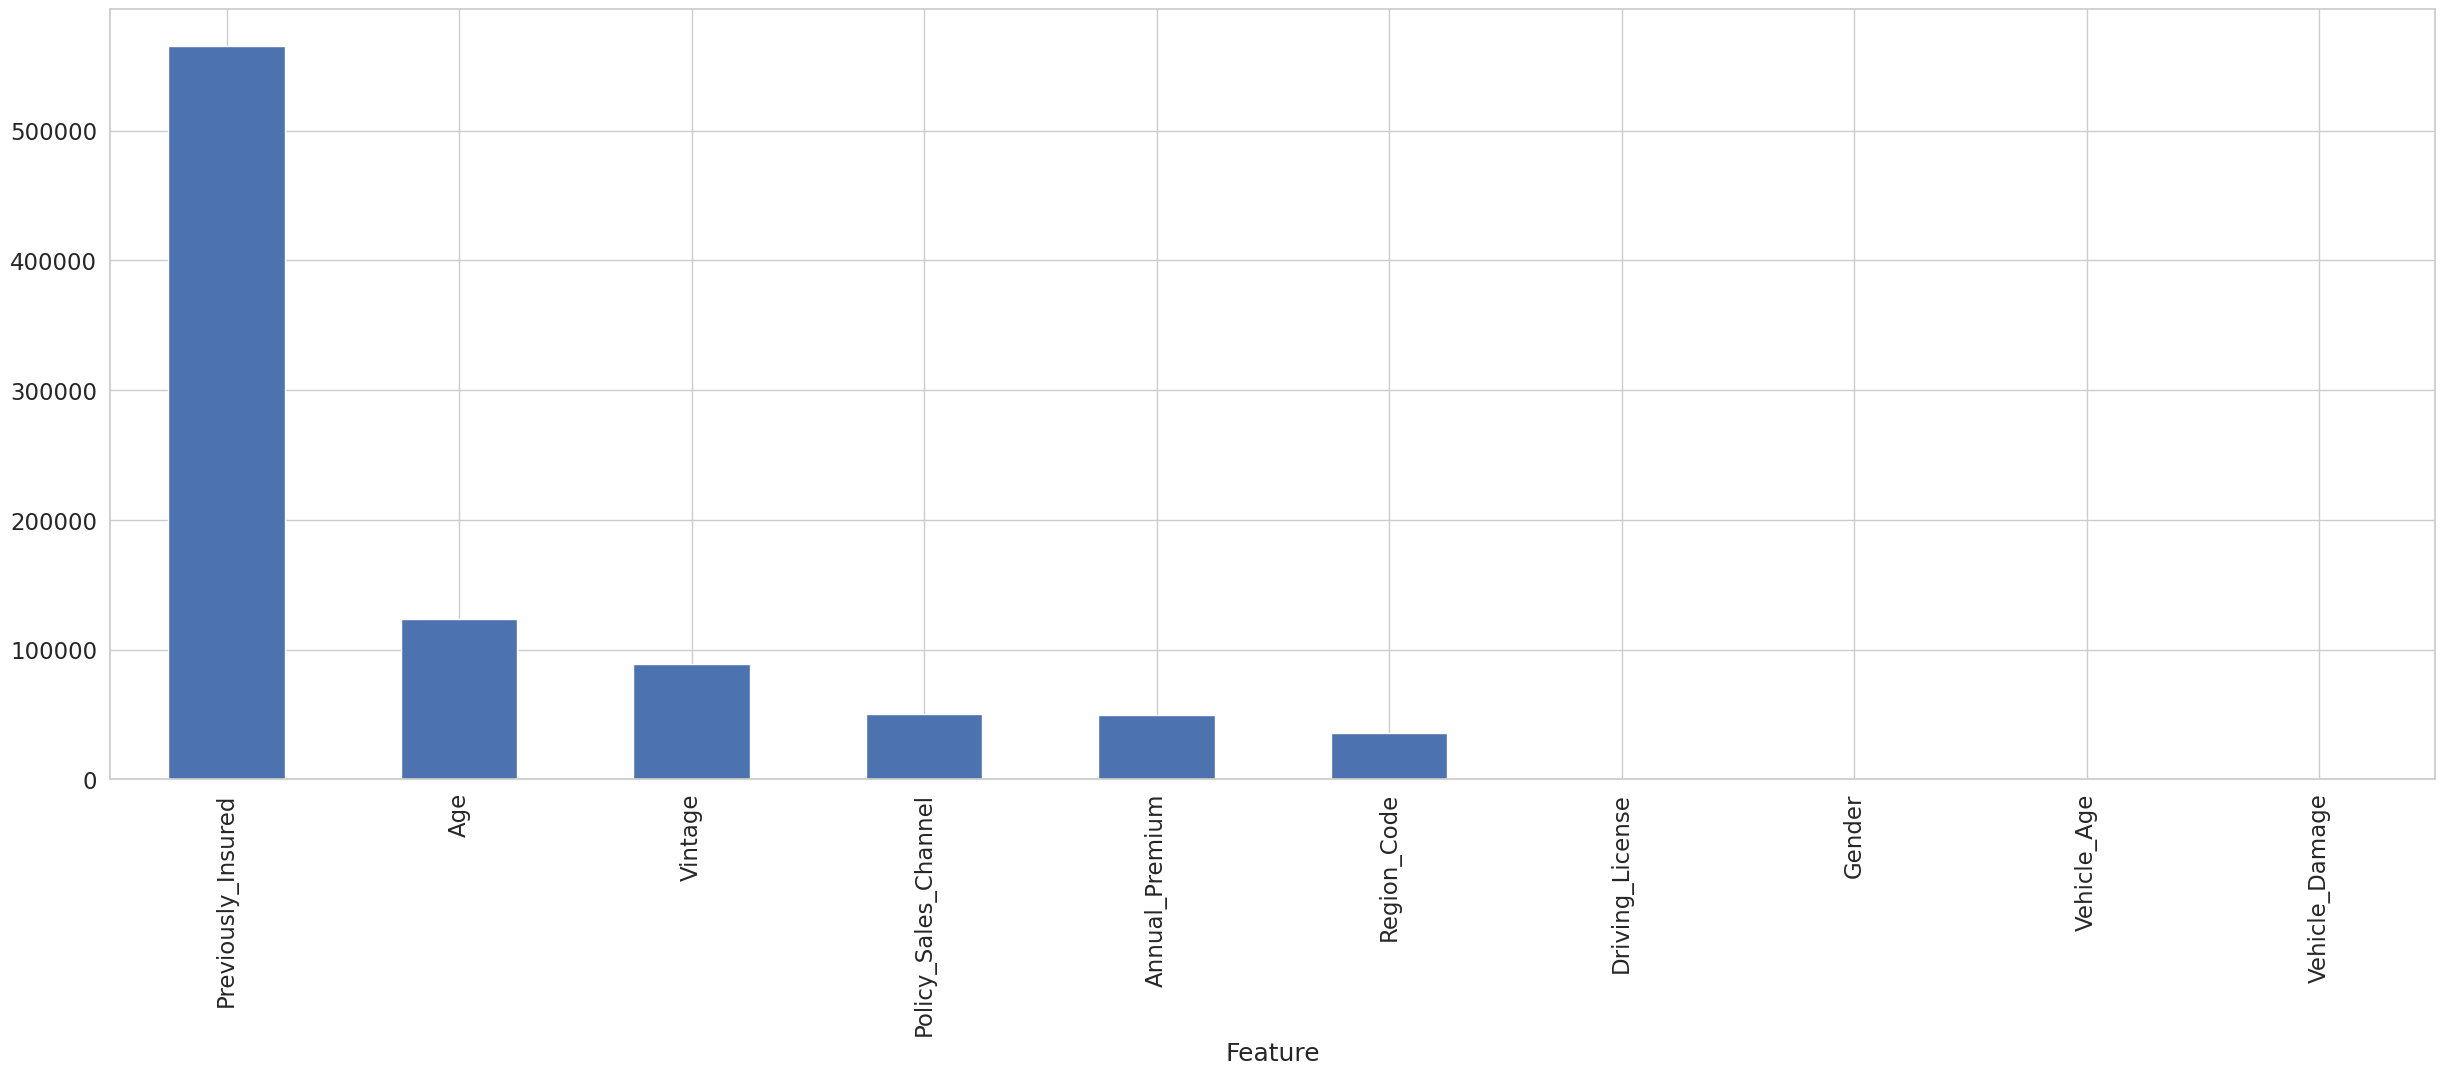

In [ ]:
%%time

fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
%%time

accurate_fi = automl_rd.model.get_feature_scores('accurate', test_data, silent = True)

CPU times: user 3h 2min 28s, sys: 39.1 s, total: 3h 3min 7s
Wall time: 1h 51min 4s


<Axes: xlabel='Feature'>

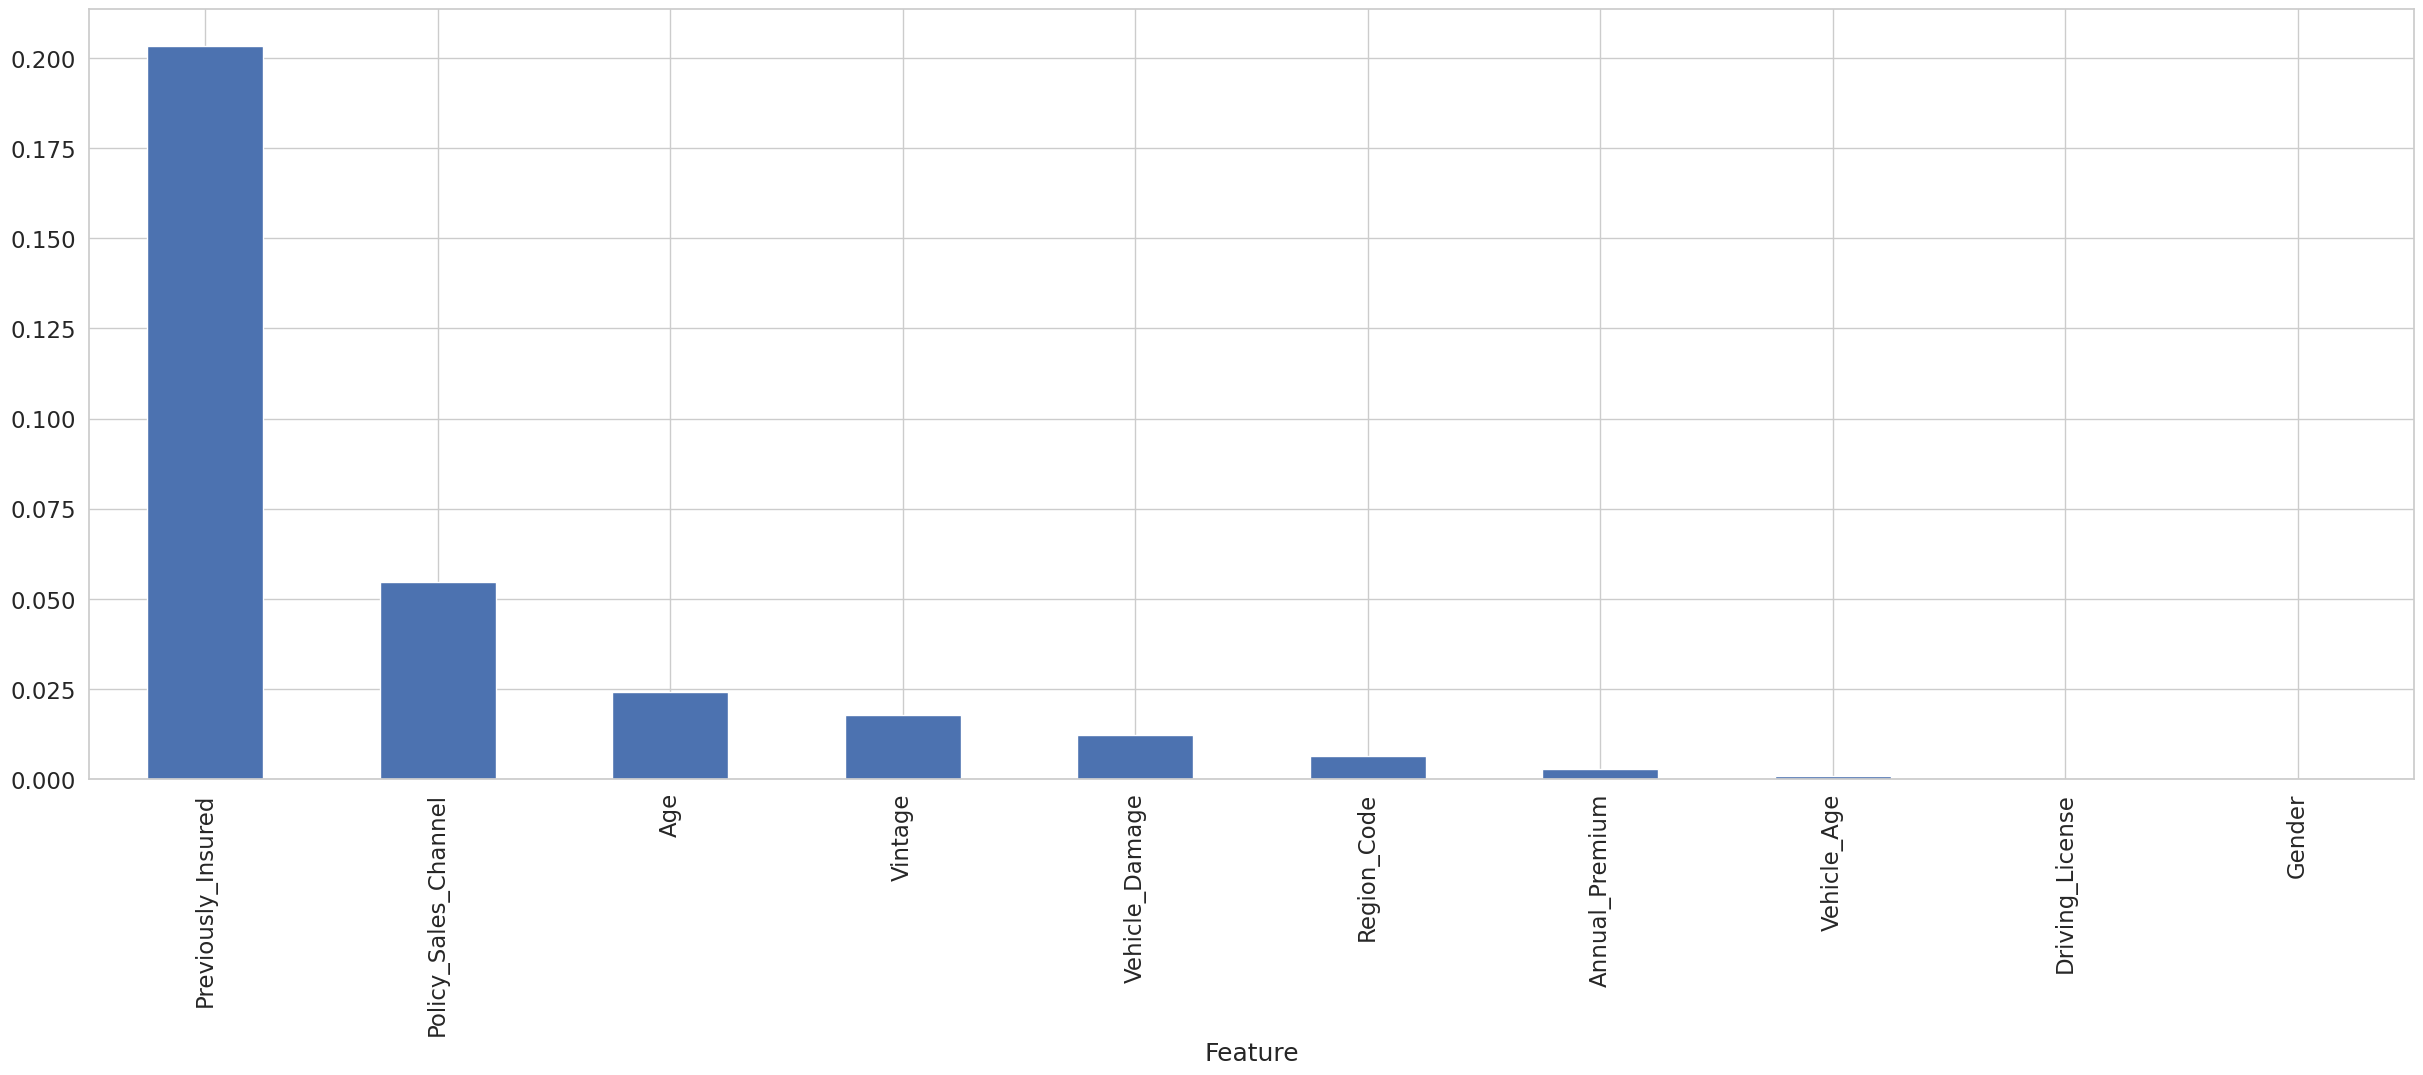

In [ ]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
print('OOF score: {}'.format(acc_score(train_data[TARGET].values, out_of_fold_predictions.data[:, 0])))
print('TEST score: {}'.format(acc_score(test_data[TARGET].values, test_predictions.data[:, 0])))

NameError: name 'train_data' is not defined

In [ ]:
train_data[TARGET_NAME].values

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
out_of_fold_predictions

array([[1.9971588e-01],
       [1.9241823e-04],
       [2.7285586e-04],
       ...,
       [1.9113779e-01],
       [2.2499993e-01],
       [7.3268375e-04]], dtype=float32)